In [1]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV, cross_validate, KFold, train_test_split

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.spatial.distance import cdist


# Loading Data

In [2]:
# just a sample of what the data is like.
ipd.Audio('./training_set/Hebron/hebron_test021.wav')

## Loading the Speach and Sampling Rates
The speach and its sampling rate will be extracted using the librosa library with the help of the `librosa.load()` function

In [3]:
sampling_rate = 44100

def load_directory(directory):
    subdirectories = ["Hebron", "Nablus", "Jerusalem", "RamallahReef"]
    audio_list = []
    labels = []
    rates = []
    
    # Iterate through each subdirectory
    for subdir in subdirectories:
        # Get the full path of the subdirectory
        subdir_path = os.path.join(directory, subdir)

        # Iterate through each file in the subdirectory
        for filename in os.listdir(subdir_path):
            # Get the full path of the file
            file_path = os.path.join(subdir_path, filename)

            # Check if the path is a file
            if os.path.isfile(file_path):
                # Load the audio file
                audio, sr = librosa.load(file_path, sr=None)
                
                # Normalize the audio to have a maximum absolute value of 1.0
                audio = librosa.util.normalize(audio)
                
                # Append audio and label
                audio_list.append(audio)
                labels.append(subdir)
                rates.append(sr)
    
    return audio_list, np.array(labels), rates

In [4]:
training_directory = './training_set'
testing_directory = './testing_set'

training_voices, Y_train, train_sr = load_directory(training_directory)
testing_voices, Y_test, test_sr = load_directory(testing_directory)

In [5]:
# Ensure all voices have the same Sampling Rate
def check_rates(train_rates, test_rates):
    unique_train_rates = set(train_rates)
    unique_test_rates = set(test_rates)
    
    print(f'Training Set Sampling Rates: {unique_train_rates} Hz')
    print('------')
    print(f'Testing Set Sampling Rates: {unique_test_rates} Hz')
    
    
check_rates(train_sr, test_sr)


Training Set Sampling Rates: {44100} Hz
------
Testing Set Sampling Rates: {44100} Hz


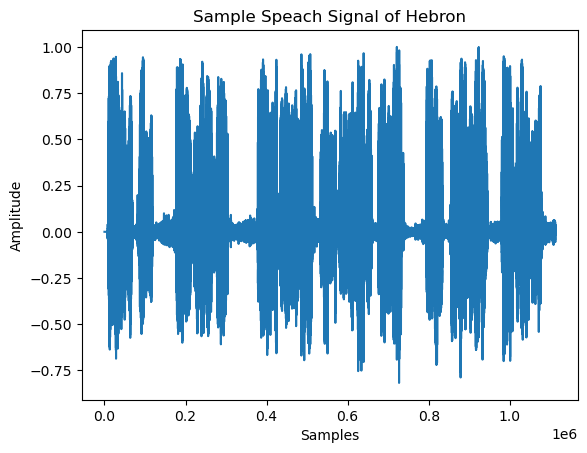

In [6]:
# Sample Sound to check if reading was correct.
plt.figure()
plt.plot(training_voices[0])

plt.title(f'Sample Speach Signal of {Y_train[0]}')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

# Data Preprocessing
## 1. Extract MFCCs and Delta Features
The MFCC features will be extracted along with the delta and delta-delta features using the `librosa.mfcc()`, and `librosa.delta()` functions.

 The `librosa.feature.mfcc()`:
* This function takes in the frame length, and in this project, the frame size was chosen to be of length 20ms.
* it also takes the hop_lenth, which is the percetange of overlap between each frame, and this is choesen to be 50%.
* lastly, the type of windowing to be applied, in which a *hamming window* was chosen in this case.


In [7]:
def get_frame_size(sampling_rate=sampling_rate, frame_duration=20): # 20 ms default frame_duration
    return int(sampling_rate * (frame_duration / 1000))

In [8]:
def extract_features(audio, frame_size, sr=sampling_rate, n_mfcc=13):

    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        hop_length=int(frame_size // 2),
        win_length=frame_size,
        window=scipy.signal.windows.hamming
    )
    delta = librosa.feature.delta(mfccs)
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    # Compute mean for each feature
    mfccs_mean = np.mean(mfccs, axis=1)
    delta_mean = np.mean(delta, axis=1)
    delta2_mean = np.mean(delta_2, axis=1)
    
    return np.hstack([mfccs_mean, delta_mean, delta2_mean])


def process_voices(audio_voices, frame_size, sr=sampling_rate, n_mfcc=13):
    features = []
    
    for voice in audio_voices:
        feature = extract_features(voice, frame_size, sr, n_mfcc)
        features.append(feature)
    
    return np.array(features)

In [9]:
X_train_unscaled = process_voices(training_voices, get_frame_size())
X_test_unscaled = process_voices(testing_voices, get_frame_size())

In [10]:
print(f'Train: {X_train_unscaled.shape}, Test: {X_test_unscaled.shape}')

print('--------')
print('Example Speech (No.5) MFCC, and Delta Features:\n')
print(X_train_unscaled[5])
print('--------')
print('Label:', Y_train[5])

Train: (40, 39), Test: (20, 39)
--------
Example Speech (No.5) MFCC, and Delta Features:

[-2.24585983e+02  1.28313934e+02  1.52787285e+01  6.83680916e+00
  4.65361595e+00  1.11334515e+01 -2.48668480e+01  2.63972068e+00
 -9.57542324e+00 -5.58716536e+00 -9.92931747e+00 -2.83026338e+00
  8.98077869e+00  6.35700207e-03  2.67761690e-03  7.98207358e-04
 -8.80345324e-05 -7.63899006e-05  3.79523000e-04 -4.33756592e-04
  9.51898619e-05 -4.95692017e-04 -1.52210458e-04  1.05139625e-04
  5.47077289e-05  3.11863550e-04 -2.67068623e-03 -1.37830828e-03
  1.51812070e-04 -1.27724688e-05 -2.04109252e-04 -2.63440306e-04
  1.80226867e-04 -1.52720808e-04 -1.98029884e-04 -5.46294541e-05
 -9.43513296e-05  1.34650007e-04 -1.79948656e-05]
--------
Label: Hebron


## 2. Scaling Data
Since the delta, and delta-delta features are extracted alongisde the MFCCs, then scaling is important since each vector has a different scale range.

**Mean-variance normalization** was applied using the `StandardScaler()` function. This will normalize data points so that all points have a mean of *zero*, and a variance of *one*.

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.fit_transform(X_test_unscaled)

In [12]:
X_train[5]

array([ 1.1445965 , -0.08206641, -1.5771579 , -0.4356035 , -1.4834977 ,
       -0.966633  , -1.3088322 , -0.81781507,  0.47486833, -0.09419902,
       -1.3267555 ,  1.4887288 ,  2.4654813 , -0.17012446, -0.24416758,
       -0.18653242, -0.4955766 , -0.35989115, -0.08090654,  0.08716942,
        0.03438106,  0.11691237,  0.10652123,  0.07161096,  0.21285403,
        0.2763125 , -0.06758229, -0.19186877,  0.12952016, -0.3290363 ,
       -0.22779581, -0.02626547, -0.01120354,  0.08873645, -0.22427481,
       -0.14257178, -0.10319731,  0.05544284,  0.13885751], dtype=float32)

# Training Phase
## 1. Supervised Models Training

### Train Simple Models

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

### Hyper-parameter Tuning

In [14]:
def tune_model(model, params: dict):
    model_grid_search = GridSearchCV(model, params, cv=kfold, n_jobs=-1, verbose=2)
    model_grid_search.fit(X_train, Y_train)
    
    return model_grid_search


svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}
rfc_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['minkowski', 'euclidean', 'cosine']
}

svm_model = tune_model(SVC(), svm_param_grid)
rfc_model = tune_model(RandomForestClassifier(random_state=42), rfc_param_grid)
knn_model = tune_model(KNeighborsClassifier(), knn_param_grid)

# SVM
print(f"Best SVM parameters: {svm_model.best_params_}")
print(f"Best Score", svm_model.best_score_)

# RFC
print(f"Best Random Forest parameters: {rfc_model.best_params_}")
print(f"Best Score", rfc_model.best_score_)

# KNN
print(f"Best KNN parameters: {knn_model.best_params_}")
print(f"Best Score", knn_model.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best SVM parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best Score 0.575
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score 0.65
Best KNN parameters: {'metric': 'cosine', 'n_neighbors': 5}
Best Score 0.625


In [15]:
# Predict on the test set
y_pred_svm = svm_model.predict(X_test)
y_pred_random_forest = rfc_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print('SVM Report:')
print(classification_report(Y_test, y_pred_svm))

print('Random Forest Report:')
print(classification_report(Y_test, y_pred_random_forest))

print('KNN Report:')
print(classification_report(Y_test, y_pred_knn))


SVM Report:
              precision    recall  f1-score   support

      Hebron       0.67      0.80      0.73         5
   Jerusalem       1.00      0.80      0.89         5
      Nablus       0.60      0.60      0.60         5
RamallahReef       0.80      0.80      0.80         5

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.75        20
weighted avg       0.77      0.75      0.75        20

Random Forest Report:
              precision    recall  f1-score   support

      Hebron       0.50      0.20      0.29         5
   Jerusalem       0.60      0.60      0.60         5
      Nablus       0.33      0.40      0.36         5
RamallahReef       0.43      0.60      0.50         5

    accuracy                           0.45        20
   macro avg       0.47      0.45      0.44        20
weighted avg       0.47      0.45      0.44        20

KNN Report:
              precision    recall  f1-score   support

      Hebron       0.57      

### SVM Confusion Matrix (best model)

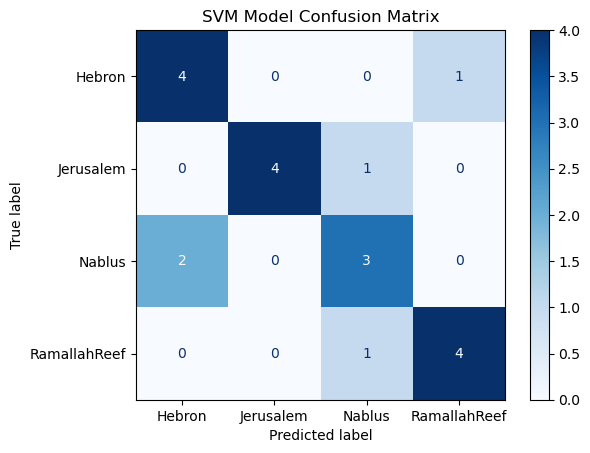

In [16]:
disp = ConfusionMatrixDisplay.from_estimator(
    svm_model,
    X_test,
    Y_test,
    cmap=plt.cm.Blues
)
plt.title('SVM Model Confusion Matrix')
plt.show()

### Random Forest Confusion Matrix (worst model)

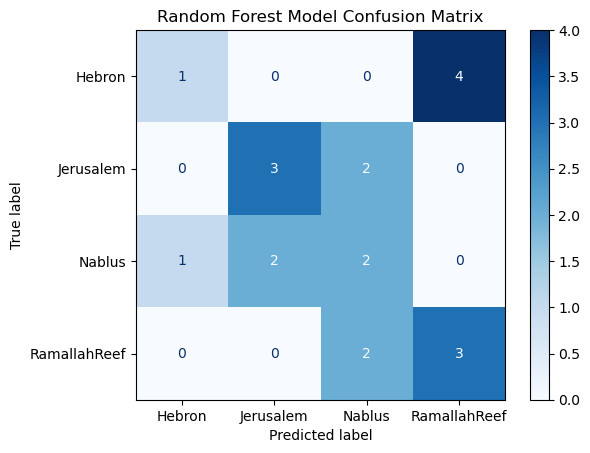

In [17]:
disp = ConfusionMatrixDisplay.from_estimator(
    rfc_model,
    X_test,
    Y_test,
    cmap=plt.cm.Blues
)
plt.title('Random Forest Model Confusion Matrix')
plt.show()

## 2. Unsupervised Techniques
We are going to try two clustering techniques:
1. k-Means Clustering.
2. Gaussian Mixture Model (GMM).

## k-Means Model

In [18]:
def create_clusters(k=5) -> dict:
    os.environ['OMP_NUM_THREADS'] = '1'
    
    # Find unique classes
    classes = np.unique(Y_train)

    # Dictionary to store the centroids for each class
    class_centroids = {}

    # Perform K-means clustering for each class
    for cls in classes:
        # Get the samples belonging to the current class
        class_samples = X_train[Y_train == cls]

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(class_samples)

        # Store the centroids
        class_centroids[cls] = kmeans.cluster_centers_
        
    return class_centroids


# Function to predict the class based on the nearest centroid
def predict_class(x, class_centroids):
    min_distance = float('inf')
    predicted_class = None
    
    # Calculate distance to each centroid and find the closest one
    for cls, centroids in class_centroids.items():
        distances = cdist([x], centroids)
        nearest_distance = np.min(distances)
        
        if nearest_distance < min_distance:
            min_distance = nearest_distance
            predicted_class = cls
            
    return predicted_class


In [ ]:
def tune_kmeans():
    kmeans_models = {}
    kmeans_scores = {}
    
    for i in range(2, 11):
        clusters = create_clusters(k=i)
        kmeans_y_pred = [predict_class(x, clusters) for x in X_test]
        
        kmeans_models[i] = kmeans_y_pred
        kmeans_scores[i] = f1_score(Y_test, kmeans_y_pred, average='macro')
        
    best_k = max(kmeans_scores.keys(), key=lambda key: kmeans_scores[key])
        
    return kmeans_models, best_k

kmeans_models, best_k = tune_kmeans()


In [43]:
# plt.style.use('fivethirtyeight')

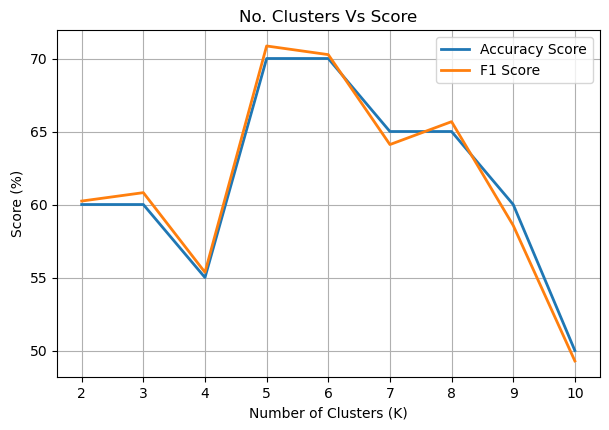

In [55]:
plt.figure(figsize=(7, 4.5))

plt.plot(
    kmeans_models.keys(),
    [accuracy_score(Y_test, pred)*100 for pred in kmeans_models.values()],
    label="Accuracy Score",
    linewidth=2
)
plt.plot(
    kmeans_models.keys(),
    [f1_score(Y_test, pred, average='macro')*100 for pred in kmeans_models.values()],
    label="F1 Score",
    linewidth=2
)

plt.title('No. Clusters Vs Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score (%)')
plt.legend()
plt.grid(True)
plt.show()


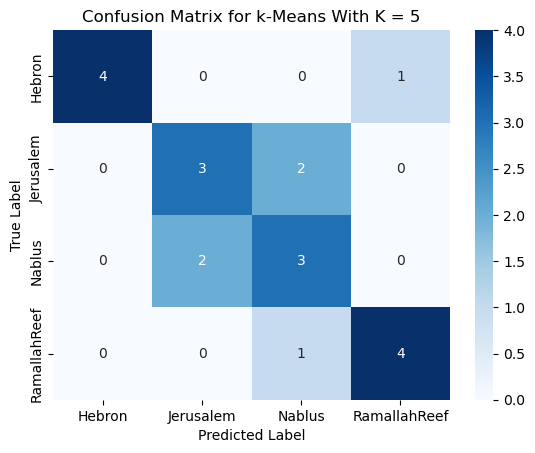

In [45]:
kmeans_matrix = confusion_matrix(Y_test, kmeans_models[best_k])

# Plot the confusion matrix using seaborn for better visualization
plt.figure()
sns.heatmap(kmeans_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for k-Means With K = {best_k}')
plt.show()


In [23]:
print("Using k-Means Clustering")
print(classification_report(Y_test, kmeans_models[best_k]))

Using k-Means Clustering
              precision    recall  f1-score   support

      Hebron       1.00      0.80      0.89         5
   Jerusalem       0.60      0.60      0.60         5
      Nablus       0.50      0.60      0.55         5
RamallahReef       0.80      0.80      0.80         5

    accuracy                           0.70        20
   macro avg       0.73      0.70      0.71        20
weighted avg       0.72      0.70      0.71        20

